# Analisis exploratorio de imagenes
Este cuaderno realiza un análisis exploratorio del dataset MOT17 con el objetivo de:

- Verificar la integridad de las anotaciones

- Analizar la distribución de objetos (peatones)

- Entender la estructura espacial y temporal del dataset

- Preparar el terreno para la detección y seguimiento


In [1]:
## Imports y configuración base

import sys
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("ggplot")

In [2]:
# Ruta base del proyecto
PROJECT_ROOT = Path("..").resolve()

# Agregar src al path
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from data_loader import load_annotations

# Selección de dataset
DATASET = "mot17"

DATA_DIR = PROJECT_ROOT / "data" / DATASET
IMAGES_DIR = DATA_DIR / "images"
ANNOTATIONS_DIR = DATA_DIR / "annotations"

# Carpeta de resultados
FIGURES_DIR = PROJECT_ROOT / "results" / "exploratorio" / DATASET
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dataset: {DATASET}")
print(f"Imágenes en: {IMAGES_DIR}")
print(f"Anotaciones en: {ANNOTATIONS_DIR}")
print(f"Figuras en: {FIGURES_DIR}")


Dataset: mot17
Imágenes en: C:\Users\monit\VisionPorComputador-trabajo_04\data\mot17\images
Anotaciones en: C:\Users\monit\VisionPorComputador-trabajo_04\data\mot17\annotations
Figuras en: C:\Users\monit\VisionPorComputador-trabajo_04\results\exploratorio\mot17


## Seleccion de split
Se identifican los splits disponibles (train, val_half, etc.) y se resumen sus tamaños.


In [3]:
ANNOTATION_FILES = {
    path.stem: path
    for path in sorted(ANNOTATIONS_DIR.glob("*.json"))
}

if not ANNOTATION_FILES:
    raise FileNotFoundError("No se encontraron archivos JSON de anotaciones")

split_rows = []
for name, path in ANNOTATION_FILES.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    split_rows.append({
        "split": name,
        "json_path": str(path),
        "num_images": len(data.get("images", [])),
        "num_annotations": len(data.get("annotations", [])),
    })

split_df = pd.DataFrame(split_rows).sort_values("split").reset_index(drop=True)
display(split_df)


,split,json_path,num_images,num_annotations
0,test,C:\Users\monit\VisionPorComputador-trabajo_04\...,17757,0
1,train,C:\Users\monit\VisionPorComputador-trabajo_04\...,5316,112297
2,train_half,C:\Users\monit\VisionPorComputador-trabajo_04\...,2664,58407
3,val_half,C:\Users\monit\VisionPorComputador-trabajo_04\...,2652,53890


## Carga del split y estadisticas iniciales
Se cargan las anotaciones y se verifica cuantas imagenes fueron localizadas en disco.


In [4]:
DATASET_KEY = "train"   # cambiar si se desea otro split
ANNOTATIONS_JSON = ANNOTATION_FILES[DATASET_KEY]

print(f"Split seleccionado: {DATASET_KEY}")
print(f"Archivo JSON: {ANNOTATIONS_JSON.name}")



Split seleccionado: train
Archivo JSON: train.json


In [5]:
imageid_to_filepath, anns_by_image, categories = load_annotations(
    str(ANNOTATIONS_JSON),
    images_dir=str(IMAGES_DIR)
)

with open(ANNOTATIONS_JSON, "r", encoding="utf-8") as f:
    raw_data = json.load(f)

images_meta = {
    im["id"]: im
    for im in raw_data.get("images", [])
}

total_images = len(imageid_to_filepath)
total_annotations = sum(len(v) for v in anns_by_image.values())
images_with_boxes = sum(1 for v in anns_by_image.values() if v)
existing_files = sum(Path(p).exists() for p in imageid_to_filepath.values())

print(f"Imágenes listadas: {total_images}")
print(f"Imágenes encontradas en disco: {existing_files}")
print(f"Imágenes con objetos: {images_with_boxes}")
print(f"Total anotaciones: {total_annotations}")
print(f"Categorías: {categories}")


Imágenes listadas: 5316
Imágenes encontradas en disco: 5316
Imágenes con objetos: 5316
Total anotaciones: 112297
Categorías: {1: 'pedestrian'}


## Vista general por imagen
Se construye una tabla resumen por imagen con número de objetos y metadatos.


In [6]:
overview_rows = []
for img_id, filepath in imageid_to_filepath.items():
    meta = images_meta.get(img_id, {})

    overview_rows.append({
        "image_id": img_id,
        "file_name": meta.get("file_name"),
        "path": filepath,
        "width": meta.get("width"),
        "height": meta.get("height"),
        "video_id": meta.get("video_id"),
        "frame_id": meta.get("frame_id"),
        "n_objects": len(anns_by_image.get(img_id, [])),
        "exists": Path(filepath).exists(),
    })

image_overview_df = pd.DataFrame(overview_rows)
display(image_overview_df.head(10))



,image_id,file_name,path,width,height,video_id,frame_id,n_objects,exists
0,1,MOT17-02-FRCNN/img1/000001.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,1,22,True
1,2,MOT17-02-FRCNN/img1/000002.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,2,22,True
2,3,MOT17-02-FRCNN/img1/000003.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,3,22,True
3,4,MOT17-02-FRCNN/img1/000004.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,4,22,True
4,5,MOT17-02-FRCNN/img1/000005.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,5,22,True
5,6,MOT17-02-FRCNN/img1/000006.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,6,22,True
6,7,MOT17-02-FRCNN/img1/000007.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,7,22,True
7,8,MOT17-02-FRCNN/img1/000008.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,8,22,True
8,9,MOT17-02-FRCNN/img1/000009.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,9,22,True
9,10,MOT17-02-FRCNN/img1/000010.jpg,C:\Users\monit\VisionPorComputador-trabajo_04\...,1920,1080,1,10,22,True


## Distribucion por categoria



,category_id,category_name,objects,frequency_pct
0,1,pedestrian,112297,100.0


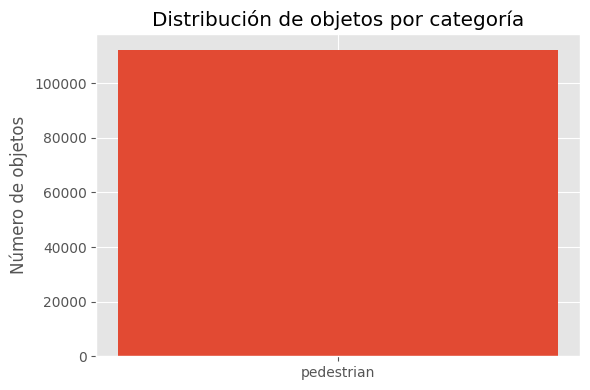

In [7]:
cat_counter = Counter()
for anns in anns_by_image.values():
    for ann in anns:
        cat_counter[ann["category_id"]] += 1

cat_df = pd.DataFrame([
    {
        "category_id": cid,
        "category_name": categories.get(cid, str(cid)),
        "objects": count,
        "frequency_pct": (count / total_annotations) * 100
    }
    for cid, count in cat_counter.items()
])

display(cat_df)

plt.figure(figsize=(6,4))
plt.bar(cat_df["category_name"], cat_df["objects"])
plt.ylabel("Número de objetos")
plt.title("Distribución de objetos por categoría")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "objects_per_category.png", dpi=150)
plt.show()


El dataset MOT17 está diseñado exclusivamente para la detección y seguimiento de peatones en escenas urbanas.
Por esta razón, la distribución por categoría se limita a una única clase (pedestrian), lo cual permite enfocar el análisis en la localización espacial y la consistencia temporal de los objetos.

## Objetos por imagen
Analiza cuántos peatones aparecen por imagen.


Media: 21.12, Mediana: 16.00, Máx: 52


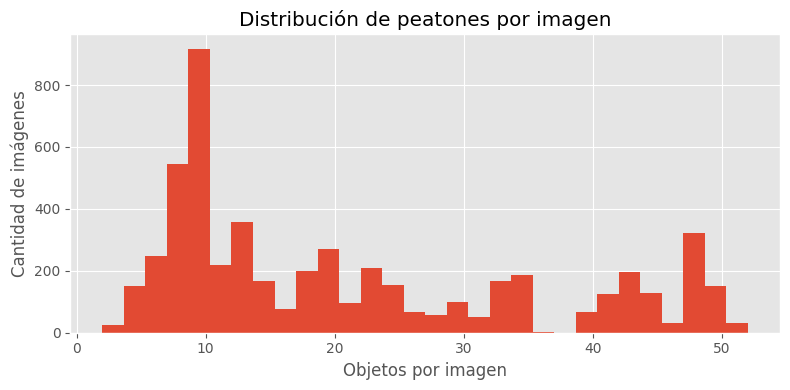

In [8]:
bbox_counts = np.array([
    len(anns_by_image.get(img_id, []))
    for img_id in imageid_to_filepath
])

print(
    f"Media: {bbox_counts.mean():.2f}, "
    f"Mediana: {np.median(bbox_counts):.2f}, "
    f"Máx: {bbox_counts.max()}"
)

plt.figure(figsize=(8,4))
plt.hist(bbox_counts, bins=30)
plt.xlabel("Objetos por imagen")
plt.ylabel("Cantidad de imágenes")
plt.title("Distribución de peatones por imagen")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "objects_per_image_hist.png", dpi=150)
plt.show()


La distribución de peatones por imagen evidencia una alta variabilidad en la densidad de las escenas.
Frames con alta concentración de objetos representan escenarios más complejos para el seguimiento, debido a oclusiones frecuentes y superposición de bounding boxes.

## Distribucion de tamanos de bounding boxes
Analiza las dimensiones de los bounding boxes en pixeles (ancho, alto y area) para el split seleccionado.


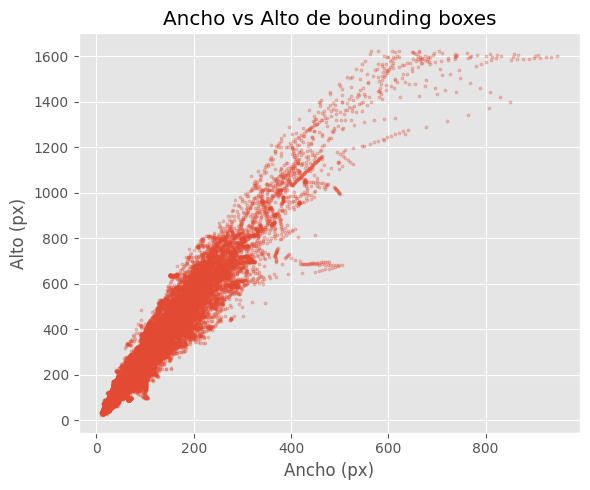

In [9]:
bbox_dims = []
for anns in anns_by_image.values():
    for ann in anns:
        x1, y1, x2, y2 = ann["bbox"]
        w = max(0, x2 - x1)
        h = max(0, y2 - y1)
        bbox_dims.append({"width": w, "height": h, "area": w * h})

bbox_df = pd.DataFrame(bbox_dims)

plt.figure(figsize=(6,5))
plt.scatter(bbox_df["width"], bbox_df["height"], alpha=0.3, s=5)
plt.xlabel("Ancho (px)")
plt.ylabel("Alto (px)")
plt.title("Ancho vs Alto de bounding boxes")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "bbox_width_vs_height.png", dpi=150)
plt.show()


La relación casi lineal entre ancho y alto refleja la geometría vertical de los peatones.
La dispersión observada se debe principalmente a efectos de perspectiva y profundidad de la escena, donde peatones más cercanos a la cámara generan bounding boxes significativamente más grandes.

## Objetos por frame (densidad)

Objetos por frame -> media: 21.12, mediana: 16.00, max: 52


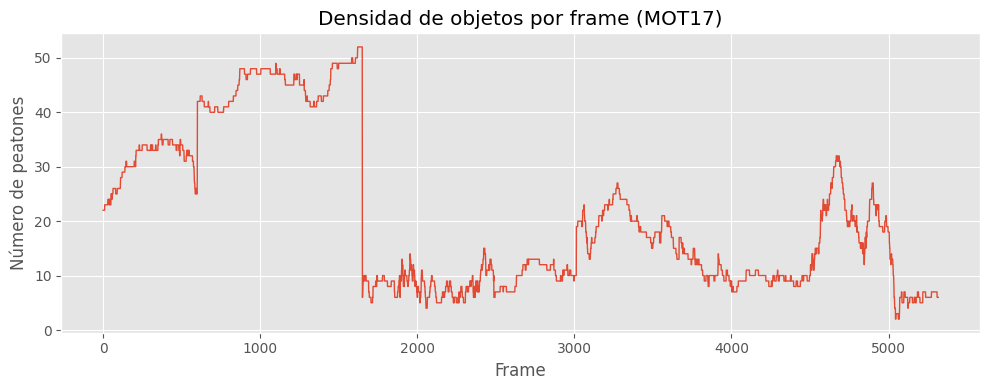

Figura guardada en: C:\Users\monit\VisionPorComputador-trabajo_04\results\exploratorio\mot17\objects_per_frame.png


In [10]:
# Contar objetos por frame
objects_per_frame = {
    frame_id: len(anns)
    for frame_id, anns in anns_by_image.items()
}

opf_df = pd.DataFrame({
    "frame_id": list(objects_per_frame.keys()),
    "n_objects": list(objects_per_frame.values())
}).sort_values("frame_id")

print(
    f"Objetos por frame -> "
    f"media: {opf_df['n_objects'].mean():.2f}, "
    f"mediana: {opf_df['n_objects'].median():.2f}, "
    f"max: {opf_df['n_objects'].max()}"
)

plt.figure(figsize=(10, 4))
plt.plot(opf_df["frame_id"], opf_df["n_objects"], linewidth=1)
plt.xlabel("Frame")
plt.ylabel("Número de peatones")
plt.title("Densidad de objetos por frame (MOT17)")
plt.grid(True)
plt.tight_layout()

out_path = FIGURES_DIR / "objects_per_frame.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f"Figura guardada en: {out_path}")


La densidad de peatones por frame presenta cambios abruptos, asociados al inicio y fin de diferentes secuencias del dataset.
Estas transiciones implican variaciones significativas en la dificultad del seguimiento a lo largo del tiempo.

## Duración de los tracks (vida útil de IDs)

Tracks totales: 546 | Duración media: 205.67 frames | Duración máxima: 1050


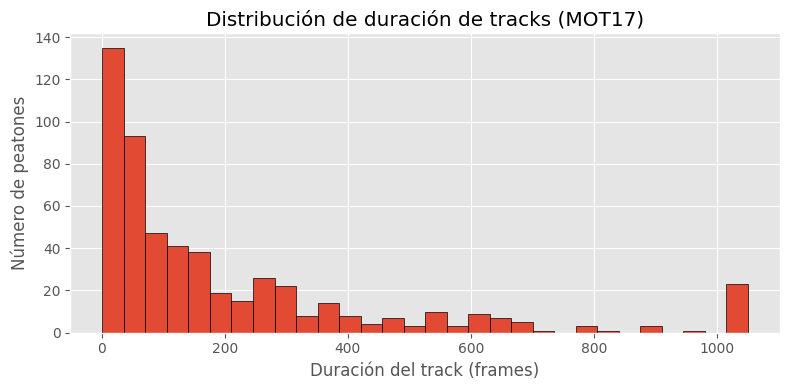

Figura guardada en: C:\Users\monit\VisionPorComputador-trabajo_04\results\exploratorio\mot17\track_durations.png


In [11]:
# Cargar anotaciones crudas
with open(ANNOTATIONS_JSON, 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# Extraer track_id explícitamente
track_ids = []

for ann in raw_data.get("annotations", []):
    if "track_id" in ann:
        track_ids.append(ann["track_id"])

track_df = pd.Series(track_ids).value_counts().reset_index()
track_df.columns = ["track_id", "num_frames"]

print(
    f"Tracks totales: {len(track_df)} | "
    f"Duración media: {track_df['num_frames'].mean():.2f} frames | "
    f"Duración máxima: {track_df['num_frames'].max()}"
)

plt.figure(figsize=(8, 4))
plt.hist(track_df["num_frames"], bins=30, edgecolor="black")
plt.xlabel("Duración del track (frames)")
plt.ylabel("Número de peatones")
plt.title("Distribución de duración de tracks (MOT17)")
plt.tight_layout()

out_path = FIGURES_DIR / "track_durations.png"
plt.savefig(out_path, dpi=150)
plt.show()

print(f"Figura guardada en: {out_path}")



## Ejemplos de imágenes con Ground Truth (MOT17)

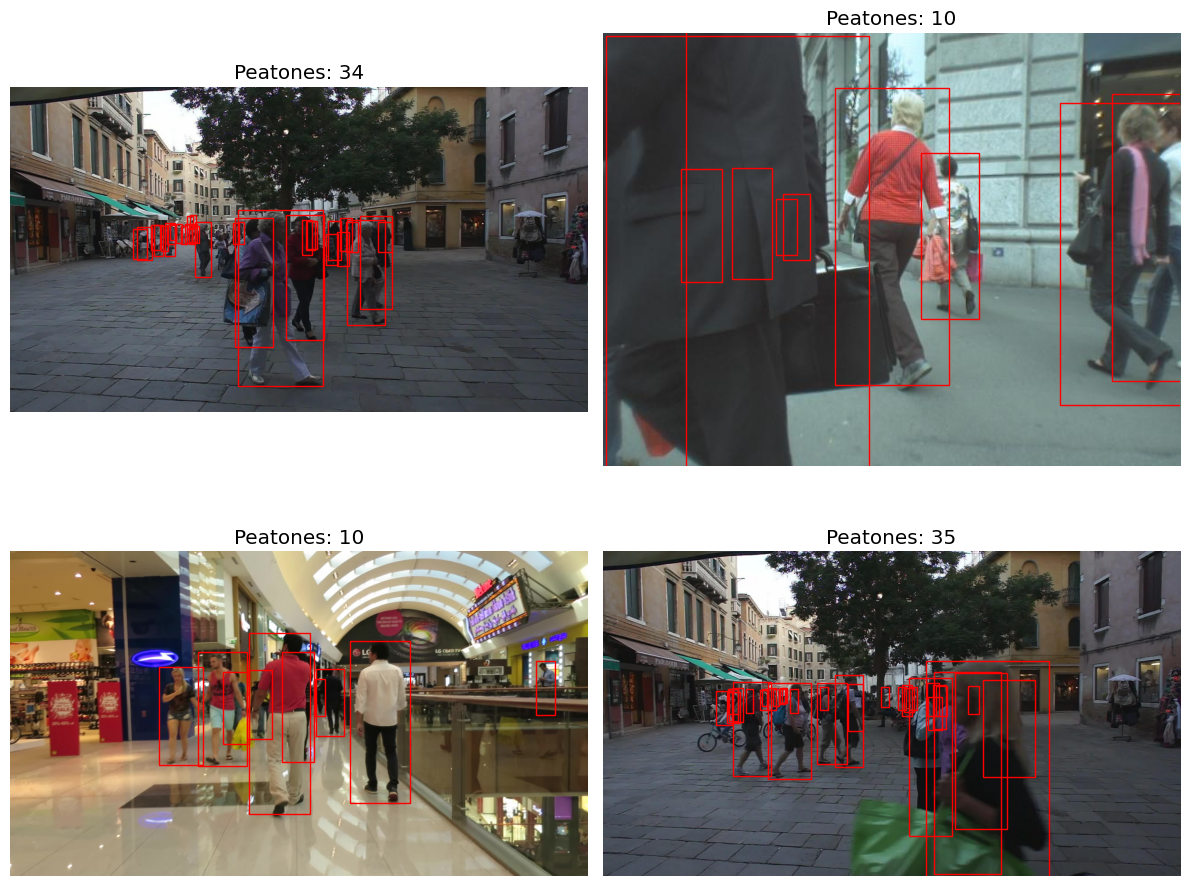

Figura guardada en: C:\Users\monit\VisionPorComputador-trabajo_04\results\exploratorio\mot17\sample_images_with_gt.png


In [12]:
samples_to_show = 4

# Seleccionar imágenes con anotaciones
annotated_ids = [img_id for img_id, anns in anns_by_image.items() if anns]

existing_df = image_overview_df[
    image_overview_df['image_id'].isin(annotated_ids) &
    image_overview_df['exists']
][['image_id', 'path']]

sample_count = min(samples_to_show, len(existing_df))

if sample_count == 0:
    print("No se encontraron imágenes anotadas para mostrar.")
else:
    sampled_df = existing_df.sample(n=sample_count, random_state=42)
    sample_records = sampled_df.to_dict("records")

    n_cols = 2
    n_rows = int(np.ceil(len(sample_records) / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(n_cols * 6, n_rows * 5)
    )
    axes = np.atleast_1d(axes).flatten()

    for ax, record in zip(axes, sample_records):
        img_id = record["image_id"]
        img_path = Path(record["path"])

        img = plt.imread(img_path)
        ax.imshow(img)
        ax.axis("off")

        anns = anns_by_image.get(img_id, [])

        # Dibujar bounding boxes GT
        for ann in anns:
            x1, y1, x2, y2 = ann["bbox"]
            w = x2 - x1
            h = y2 - y1
            rect = plt.Rectangle(
                (x1, y1),
                w,
                h,
                linewidth=1,
                edgecolor="red",
                facecolor="none"
            )
            ax.add_patch(rect)

        ax.set_title(f"Peatones: {len(anns)}")

    for ax in axes[len(sample_records):]:
        ax.axis("off")

    plt.tight_layout()

    out_path = FIGURES_DIR / "sample_images_with_gt.png"
    plt.savefig(out_path, dpi=150)
    plt.show()

    print(f"Figura guardada en: {out_path}")
